Méthode Fama-Macbeth

# Le modèle Fama-French à cinq facteurs

Le modèle Fama-French à cinq facteurs est une extension des modèles précédents de Fama et French, notamment leur modèle à trois facteurs. Il a été proposé par Eugene F. Fama et Kenneth R. French en 2015 et vise à expliquer les rendements des actions en utilisant cinq facteurs. Voici une brève explication de chaque facteur :

## Marché (MKT)

Ce facteur est le rendement du marché global, souvent mesuré par la différence entre le rendement d'un portefeuille de marché large (comme l'indice S&P 500) et le rendement d'un actif sans risque (comme les bons du Trésor à court terme).

## Taille (SMB, Small Minus Big)

Ce facteur capture l'effet de taille, basé sur la capitalisation boursière. Il est calculé comme la différence entre les rendements des portefeuilles d'actions de petites capitalisations et ceux de grandes capitalisations. Historiquement, les actions de petites entreprises ont tendance à surperformer celles de grandes entreprises.

## Valeur (HML, High Minus Low)

Ce facteur mesure l'effet valeur, basé sur le rapport valeur comptable/valeur de marché (B/M). Il est calculé comme la différence entre les rendements des portefeuilles d'actions à forte valeur (valeur comptable élevée par rapport à la valeur de marché) et à faible valeur (valeur comptable faible par rapport à la valeur de marché). Les actions de valeur ont historiquement surperformé les actions de croissance.

## Rentabilité (RMW, Robust Minus Weak)

Ce facteur capture l'effet de la rentabilité opérationnelle. Il est calculé comme la différence entre les rendements des portefeuilles d'actions d'entreprises ayant une rentabilité opérationnelle robuste et celles ayant une rentabilité opérationnelle faible.

## Investissement (CMA, Conservative Minus Aggressive)

Ce facteur mesure l'effet de l'investissement en capital. Il est calculé comme la différence entre les rendements des portefeuilles d'actions d'entreprises ayant des politiques d'investissement conservatrices (faibles taux d'investissement) et celles ayant des politiques d'investissement agressives (taux d'investissement élevés).

## Formule du modèle Fama-French à cinq facteurs

La formule du modèle peut être exprimée comme suit :


$$
R_i - R_f = \alpha + \beta_1 (R_m - R_f) + \beta_2 \text{SMB} + \beta_3 \text{HML} + \beta_4 \text{RMW} + \beta_5 \text{CMA} + \epsilon_i
$$

où :

- \( $R_i$ \) est le rendement du portefeuille ou de l'action \( i \).
- \( $R_f$ \) est le taux sans risque.
- \( $R_m$ \) est le rendement du marché.
- \( $\alpha$ \) est l'alpha du modèle (l'interception).
- \( $\beta_1$, $\beta_2$, $\beta_3$, $\beta_4$, $\beta_5$ \) sont les coefficients des facteurs.
- \( $\epsilon_i$ \) est le terme d'erreur.


## Utilisation du modèle

Le modèle Fama-French à cinq facteurs est utilisé par les chercheurs, les gestionnaires de portefeuille et les investisseurs pour :

- Mieux comprendre les sources de rendements des actions.
- Évaluer la performance ajustée pour le risque des gestionnaires de fonds.
- Concevoir des portefeuilles d'investissement en tenant compte des facteurs de risque supplémentaires identifiés.

En résumé, le modèle Fama-French à cinq facteurs étend les modèles précédents en ajoutant deux nouveaux facteurs, la rentabilité et l'investissement, afin d'améliorer l'explication des rendements des actions.


# Sources des Données et Entreprises Incluses

## CRSP (Center for Research in Security Prices)
Cette base de données comprend des informations sur les prix des actions, les dividendes, les volumes de transactions, et d'autres données relatives aux actions de toutes les entreprises cotées en bourse aux États-Unis, y compris celles cotées sur le NYSE, l'AMEX, et le NASDAQ.

## Compustat
Cette base de données fournit des informations financières détaillées sur les entreprises, y compris les états financiers, les ratios financiers, et d'autres indicateurs de performance.

# Entreprises Incluses
Les entreprises utilisées pour calculer les facteurs de Fama-French comprennent généralement :

- **Grandes capitalisations** : Entreprises avec une capitalisation boursière élevée, souvent incluses dans des indices comme le S&P 500.
- **Petites capitalisations** : Entreprises avec une capitalisation boursière plus faible.
- **Actions de valeur** : Entreprises avec un ratio valeur comptable/valeur de marché (B/M) élevé.
- **Actions de croissance** : Entreprises avec un ratio valeur comptable/valeur de marché (B/M) faible.
- **Entreprises rentables** : Entreprises avec une rentabilité opérationnelle robuste.
- **Entreprises moins rentables** : Entreprises avec une rentabilité opérationnelle faible.
- **Entreprises conservatrices** : Entreprises avec des politiques d'investissement conservatrices.
- **Entreprises agressives** : Entreprises avec des politiques d'investissement agressives.

# Processus de Calcul
Les chercheurs Fama et French utilisent les étapes suivantes pour calculer les facteurs :

1. **Collecte des Données** : Récupération des prix des actions, des états financiers, et d'autres données financières pertinentes pour toutes les entreprises cotées en bourse.
2. **Construction des Portefeuilles** : Les entreprises sont classées en fonction de leur capitalisation boursière (petites vs grandes), de leur ratio B/M (valeur vs croissance), de leur rentabilité opérationnelle, et de leur politique d'investissement. Des portefeuilles sont ensuite formés en regroupant les entreprises en fonction de ces caractéristiques.
3. **Calcul des Rendements** : Les rendements des portefeuilles formés sont calculés sur une base mensuelle ou annuelle.
4. **Calcul des Facteurs** : Les facteurs SMB, HML, RMW, et CMA sont calculés comme les différences de rendements entre les portefeuilles correspondant aux différentes caractéristiques (par exemple, petites capitalisations moins grandes capitalisations pour SMB).

# Exemple d'Entreprises Potentielles
Bien que le dataset ne mentionne pas spécifiquement les noms des entreprises individuelles, il est probable qu'il inclue des entreprises bien connues telles que :

- **Grandes Capitalisations** : Apple, Microsoft, Google (Alphabet), Amazon, etc.
- **Petites Capitalisations** : De nombreuses petites entreprises cotées sur les bourses américaines, dont les noms peuvent varier.


In [1]:
import warnings
warnings.filterwarnings('ignore') # pour éviter les avertissements et errors dans certaines manipulations

In [2]:
import pandas as pd # pour manipuler des dataframes
import numpy as np # pour manipuler des tableaux
from statsmodels.api import OLS, add_constant # pour réaliser des régression linéaires
import pandas_datareader.data as web # pour extraire des données
import pandas_datareader.famafrench as ff # pour accéder au module de famafrench
from linearmodels.asset_pricing import LinearFactorModel # pour calculer des betas
import matplotlib.pyplot as plt # pour dessiner
import seaborn as sns # pour dessiner
from statsmodels.api import RLM #  utile pour lancer une régression robuste
from datetime import datetime # pour manipuler des dates
import yfinance as yf # pour importer des données boursières de yahoo finance

In [3]:
sns.set_style('whitegrid') # facultatif, juste pour le style de certains graphiques, une grille une fond

#### Voici le site de Fama et French sur lequel vous trouverez en libre accès des données pour réaliser nos modèles https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [4]:
# Regardons dans un premier temps tous les datasets disponibles dans le module famafrench

# code pour récupérer tous les datasets disponibles dans la module famafrench
famafrench_datasets = ff.get_available_datasets()

# On a récupéré les datasets disponibles juste au dessus, on fait une boucle pour
# imprimer leur nom un par un 
for dataset in famafrench_datasets:
    print(dataset)

F-F_Research_Data_Factors
F-F_Research_Data_Factors_weekly
F-F_Research_Data_Factors_daily
F-F_Research_Data_5_Factors_2x3
F-F_Research_Data_5_Factors_2x3_daily
Portfolios_Formed_on_ME
Portfolios_Formed_on_ME_Wout_Div
Portfolios_Formed_on_ME_Daily
Portfolios_Formed_on_BE-ME
Portfolios_Formed_on_BE-ME_Wout_Div
Portfolios_Formed_on_BE-ME_Daily
Portfolios_Formed_on_OP
Portfolios_Formed_on_OP_Wout_Div
Portfolios_Formed_on_OP_Daily
Portfolios_Formed_on_INV
Portfolios_Formed_on_INV_Wout_Div
Portfolios_Formed_on_INV_Daily
6_Portfolios_2x3
6_Portfolios_2x3_Wout_Div
6_Portfolios_2x3_weekly
6_Portfolios_2x3_daily
25_Portfolios_5x5
25_Portfolios_5x5_Wout_Div
25_Portfolios_5x5_Daily
100_Portfolios_10x10
100_Portfolios_10x10_Wout_Div
100_Portfolios_10x10_Daily
6_Portfolios_ME_OP_2x3
6_Portfolios_ME_OP_2x3_Wout_Div
6_Portfolios_ME_OP_2x3_daily
25_Portfolios_ME_OP_5x5
25_Portfolios_ME_OP_5x5_Wout_Div
25_Portfolios_ME_OP_5x5_daily
100_Portfolios_ME_OP_10x10
100_Portfolios_10x10_ME_OP_Wout_Div
100_Port

In [26]:
# On choisit le dataset F-F_Research_Data_5_Factors_2x3 
famafrench_factor = 'F-F_Research_Data_5_Factors_2x3'

# Maintenant on récupère ce dataset avec web.DataReader
# On donne à la fonction le nom du dataset, la data source et la période
# Ici on ne précise pas encore les dates qu'on veut récupérer, dans un premier temps on regarde
# Jusqu'où va se dataset
famafrench_factor_data = web.DataReader(famafrench_factor, 'famafrench')[0]

# On récupère la dernière date du dataset avec .index[-1] '-1' étant la première position quand 
# on part de bas, puis -2, -3, etc...
derniere_date = famafrench_factor_data.index[-1]

derniere_date
# On s'aperçoit que le dataset est disponible pour des dates allant de juillet 2019 jusqu'à Mai 2024

Period('2024-05', 'M')

In [27]:
famafrench_factor = 'F-F_Research_Data_5_Factors_2x3'

# On en profite pour prendre toute la période, on peut ou non expliciter les dates, nous le faisons
# pour que vous puissiez vous entrainer à spécifier des périodes lors de votre requête
famafrench_factor_data = web.DataReader(famafrench_factor, 'famafrench', start='2017-07', end='2024-05')[0]

In [28]:
# pour pouvoir manipuler plus facilement le dataset et plot des graphiques il est convenable de
# changer le type de la première conlonne en type date.
# En effet, de base on lit bien une date mais l'index mais pas un objet de type date c'est un objet de
# type PERIOD et c'est moins pratique pour afficher un graphique.

# Dans ce code on sélectionne l'index de notre dataset, ici la colonne de dates et on transforme
# le type de cet index en ojbet de type DATE. De base c'est un objet de type PERIOD
famafrench_factor_data.index = famafrench_factor_data.index.to_timestamp()
famafrench_factor_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2017-07-01,1.87,-1.69,-0.31,-0.64,-0.20,0.07
2017-08-01,0.16,-1.82,-2.09,0.14,-2.38,0.09
2017-09-01,2.51,4.78,3.14,-1.47,1.69,0.09
2017-10-01,2.25,-1.94,0.20,0.93,-3.25,0.09
2017-11-01,3.12,-0.33,-0.03,3.16,-0.05,0.08


#### la colonnne RMW signifie en Anglais Robust Minus Weak, autrement dit -> Rendement moyen des deux portefeuilles à forte rentabilité opérationnelle moins le rendement moyen des deux portefeuilles à faible rentabilité opérationnelle

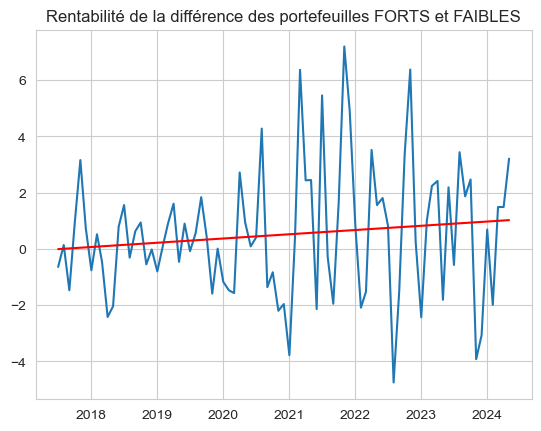

In [8]:
# Dessinons ce rendement moyen sur la période complète pour avoir une idée de la façon dont il bouge

# On va tracer une droite de tendance en + sur le graphique
# préparons les données des abscisses 'x' pour la bonne longueur, celle du dataset
# les données 'x' vont servir au calcul de la droite de régression
x = np.arange(len(famafrench_factor_data))


# Calculer la droite de régression linéaire
# On commence par calculer la pente 'slope' et l'ordonnée à l'origine 'intercept'
slope, intercept = np.polyfit(x, famafrench_factor_data['RMW'], 1) # 1 pour polynome de degré 1 type ax+b
linear_fit = slope * x + intercept

# Tracer les données
plt.plot(famafrench_factor_data['RMW'])
plt.title('Rentabilité de la différence des portefeuilles FORTS et FAIBLES')

# Tracer la droite de régression
plt.plot(famafrench_factor_data['RMW'].index, 
         linear_fit, 
         color='red', 
         label=f'Droite de régression (pente={slope:.4f})')

Le rendement moyen de la différence des portefeuilles est :  0.5085542168674699  %


Text(0, 0.5, 'Effectifs')

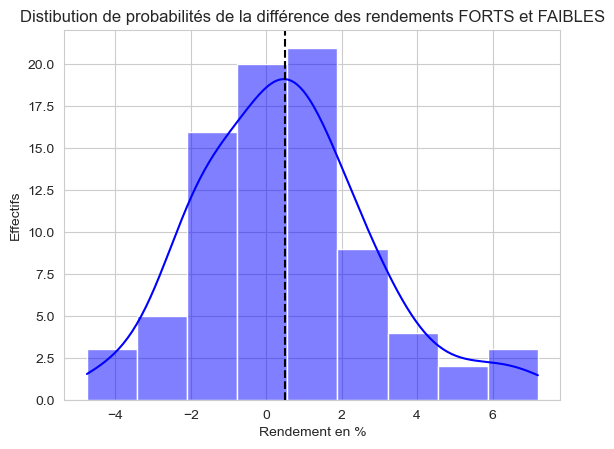

In [9]:
# Dessinons la distribution du rendement de la différence des portefeuilles robuste et faibles sur la 
# période 
# plt.hist(famafrench_factor_data['RMW'], color='blue')

rendement_moyen_diff_portefeuilles = famafrench_factor_data['RMW'].mean()

# avec la méthode de plot suivante et le module seaborn on peut ploter la densité continue en plus
sns.histplot(famafrench_factor_data['RMW'], kde=True, color='blue')

print('Le rendement moyen de la différence des portefeuilles est : ' ,
      rendement_moyen_diff_portefeuilles,
     ' %')

# On trace la moyenne en tant que barre verticale et on donne des caractéristiques pour notre tracé
plt.axvline(rendement_moyen_diff_portefeuilles, 
           linestyle='dashed',
           linewidth=1.5,
            color='black',
           label=f'Moyenne = {rendement_moyen_diff_portefeuilles:.2f}')


plt.title('Distibution de probabilités de la différence des rendements FORTS et FAIBLES')
plt.xlabel('Rendement en %')
plt.ylabel('Effectifs')

# On s'aperçoit que la différence des rendements tourne en moyenne autour de 0 mais 

#### Pour calculer les betas dans un modèle MEDAF (Modèle d'évaluation des actifs financiers) appelé CAPM en Anglais (Capital Asset Pricing Model) il faut soustraire au rendement du portefeuille le taux sans risque. Ce taux sans risque est justement déjà présent dans le dataframe dans la colonne RF

In [10]:
# Rapide analyse du taux sans risque RF (Risk Free) sur la période complète 
# On print le mininimum de ce taux et son maximum avec les dates pour lesquelles
# le min et le max ont été réalisés

minimum_taux_sans_risque = famafrench_factor_data['RF'].min()
maximum_taux_sans_risque = famafrench_factor_data['RF'].max()

date_min_taux_sans_risque = famafrench_factor_data['RF'].idxmin()
date_max_taux_sans_risque = famafrench_factor_data['RF'].idxmax()

annee_min_taux_sans_risque = date_min_taux_sans_risque.year
mois_min_taux_sans_risque = date_min_taux_sans_risque.month
jour_min_taux_sans_risque = date_min_taux_sans_risque.day

annee_max_taux_sans_risque = date_max_taux_sans_risque.year
mois_max_taux_sans_risque = date_max_taux_sans_risque.month
jour_max_taux_sans_risque = date_max_taux_sans_risque.day

print('Le mininimum du taux sans risque est : {}% et a été atteint le : {} / {} / {}'
      .format(minimum_taux_sans_risque,
             jour_min_taux_sans_risque,
             mois_min_taux_sans_risque,
             annee_min_taux_sans_risque
             ))

print('Le maximum du taux sans risque est : {}% et a été atteint le : {} / {} / {}'
      .format(maximum_taux_sans_risque,
             jour_max_taux_sans_risque,
             mois_max_taux_sans_risque,
             annee_max_taux_sans_risque
             ))

Le mininimum du taux sans risque est : 0.0% et a été atteint le : 1 / 4 / 2020
Le maximum du taux sans risque est : 0.47% et a été atteint le : 1 / 10 / 2023


Maintenant que nous avons récupéré le dataset les facteurs qui pourraient potetiellement expliquer le rendement d'une action selon Fama et French, nous allons estimer ces facteurs. C'est à dire que nous allons trouver les meilleurs betas avec une régression linéaire qui nous donnent l'effet moyen de ces facteurs sur le rendement d'une action.

Par exemple, si on s'intéresse au facteur RMW qui rappelons le représente la différence entre les entreprises à forte rentabilité opérationnelle et les entreprises à faible rentabilité opérationnelle, le coefficient β_RMW mesure la sensibilité du rendement du portefeuille ou de l'action aux variations du facteur RMW. En d'autres termes, il indique dans quelle mesure les rendements du portefeuille ou de l'action sont influencés par les différences de rentabilité opérationnelle des entreprises.

𝛽_RMW > 0 : Si β_RMW est positif, cela signifie que le portefeuille ou l'action a tendance à surperformer lorsque les entreprises à haute rentabilité (robuste) surperforment les entreprises à faible rentabilité (faible). En d'autres termes, le portefeuille ou l'action est positivement exposé à la rentabilité opérationnelle.

#### Nous possédons le dataset famafrench_factor_data dans lequel on a nos 5 facteurs, maintenant il nous faut le dataset des portefeuilles qui ont été justement classés selon ces facteurs. On va récupérer ce dataset et ensuite on pourra lancer la régression linéaire pour estimer l'effet de ces facteurs sur les rendements d'une action. L'objectif ? Une fois que vous connaissez par exemple l'effet de la différence de rentabilité opérationnelle entre une entreprise à forte rentbailité opérationnelle et une entreprise à faible rentabilité opérationnelle, vous connaissez donc le beta, celà vous permet d'analyser vous même des données et d'anticiper ou simplement calculer quelle rentabilité attendre de votre action. Par exemple : si vous trouvez que l'effet (le beta) de la différence de rentabilité entres les actions à forte rentabilité opérationnelle et faible rentabilité opérationnelle est de '1,2' (au hasard), celà signifie que si la différence de rentbailités opérationnelles augmente de '1', alors le rendement de votre action (si elle est classé dans la catégorie forte rentabilité opérationnelle) devra augmenter de '1 * 1.2' en rendement. 

_Contenu du Dataset :_  <br><br>
*Période de Données :*

Les données couvrent une période étendue, souvent plusieurs décennies, avec des observations mensuelles.
Rendements des Portefeuilles :

Chaque ligne du dataset represente les rendements mensuels d un portefeuille spécifique qui appartient à l'une des 17 industries définies par Fama et French.
Les rendements sont généralement ajustés pour tenir compte des dividendes et autres distributions. <br> <br>
  
  
*Objectifs de l'Analyse :*

Si votre objectif est d'évaluer comment les rendements des différentes industries (représentées dans le dataset) sont influencés par les facteurs spécifiques du modèle à cinq facteurs, alors ce dataset peut être pertinent. Par exemple, vous pourriez étudier comment les industries réagissent aux variations du marché global (MKT), aux différences de taille (SMB), de valeur (HML), de rentabilité opérationnelle (RMW) et de politique d'investissement (CMA).

In [34]:
famafrench_portefeuilles = '17_Industry_Portfolios'
famafrench_portefeuilles_data = web.DataReader(famafrench_portefeuilles, 'famafrench', start='2017-07', end='2024-05')[0]
famafrench_portefeuilles_data.head()
# Les rendements mensuels sont en %


# Comme nous l'avions fait pour le premier dataset nous convertissons l'index en objet de type
# date avec la méthode .to_timestamp()
famafrench_portefeuilles_data.index = famafrench_portefeuilles_data.index.to_timestamp()
famafrench_portefeuilles_data.head()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
Date,,,,,,,,,,,,,,,,,
2017-07-01,1.64,8.23,1.88,1.44,-4.76,1.97,0.16,-1.34,1.31,0.86,2.98,-1.62,0.30,2.99,0.73,1.85,2.93
2017-08-01,-1.80,0.79,-5.12,-4.32,-3.76,1.63,0.60,-0.38,1.67,-1.42,1.33,0.86,1.63,2.17,-1.29,-1.29,1.69
2017-09-01,-0.27,-1.12,10.98,1.22,4.48,7.06,0.69,7.83,3.73,7.38,5.72,7.53,4.75,-1.95,0.72,5.27,0.25
2017-10-01,0.98,1.23,0.41,3.05,-1.64,4.79,-3.63,4.08,2.23,1.76,6.16,1.16,-0.24,3.02,4.07,3.37,2.54
2017-11-01,4.25,0.86,2.88,7.30,3.83,2.32,2.70,6.98,-1.39,0.38,2.40,2.52,5.56,2.42,8.86,3.96,1.75


In [12]:
# Par contre attention avant de réaliser la régression, dans le dataset des 5 caractéristiques
# les rendements sont aussi en % mais ces rendements sont diminués du taux sans risque RF, alors
# que dans notre dataset '17_Industry_Portfolios' les rendements sont purs. Il faut donc soustraire
# le taux sans risque RF afin de comparer ce qui est comparable ;)


# On prépare une petit boût de code pour vérifier pendant la soustraction sur chaque ligne du dataset
# que tout se passe bien. Si les datasets n'ont pas la même shape alors le code nous le dira
# en nous renvoyant une erreur et dans ce cas il ne pourra pas réaliser l'opération de soustraction
# du taux sans risque étant donné que les datasets n'auraient pas la même shape. Auquel cas il faudra
# réaligner parfaitement leur shape. Si le code ne nous renvoie pas d'erreur alors il aura pu réaliser
# la soustraction sur toutes les valeurs du dataset portefeuilles
if famafrench_portefeuilles_data.shape[0] != famafrench_factor_data.shape[0]:
    raise ValueError("Les deux DataFrames doivent avoir le même nombre de lignes")

# Pour réaliser la soustraction sans trop forcer sur toutes les valeurs de dataset portefeuille,
# la fonction .sub nous permet de faire celà. Il faut commencer par invoquer le dataset auquel on 
# veut soustraite des valeurs, ensuite on ajoute .sub() et entre paranthèses on donne la valeur 
# à soustraire, ici famafrench_factor_data['RF'], autrement dit la valeur RF taux sans risque de chaque
# ligne du dataset famafrench_factor_data, puis on précise à la fonction axis=0 pour dire qu'il faut 
# soustraire cette valeur ligne par ligne sans en oublier aucune. 
# Ce nouveau dataset de 17 portefeuilles auquel le taux sans risque a été soustrait sera stocké dans
# un nouveau dataset du même nom que l'ancien : famafrench_portefeuilles_data
famafrench_portefeuilles_data = famafrench_portefeuilles_data.sub(famafrench_factor_data['RF'], axis=0).head()

# Petite vérif visuelle que tout s'est bien passé
famafrench_portefeuilles_data.head()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
Date,,,,,,,,,,,,,,,,,
2017-07-01,1.57,8.16,1.81,1.37,-4.83,1.90,0.09,-1.41,1.24,0.79,2.91,-1.69,0.23,2.92,0.66,1.78,2.86
2017-08-01,-1.89,0.70,-5.21,-4.41,-3.85,1.54,0.51,-0.47,1.58,-1.51,1.24,0.77,1.54,2.08,-1.38,-1.38,1.60
2017-09-01,-0.36,-1.21,10.89,1.13,4.39,6.97,0.60,7.74,3.64,7.29,5.63,7.44,4.66,-2.04,0.63,5.18,0.16
2017-10-01,0.89,1.14,0.32,2.96,-1.73,4.70,-3.72,3.99,2.14,1.67,6.07,1.07,-0.33,2.93,3.98,3.28,2.45
2017-11-01,4.17,0.78,2.80,7.22,3.75,2.24,2.62,6.90,-1.47,0.30,2.32,2.44,5.48,2.34,8.78,3.88,1.67


In [13]:
# Utiliser .loc pour sélectionner et aligner famafrench_factor_data sur famafrench_portefeuilles_data
famafrench_factor_data = famafrench_factor_data.loc[famafrench_portefeuilles_data.index]

# Vérifier les index après l'alignement
print(famafrench_factor_data.index.equals(famafrench_portefeuilles_data.index))

True


#### On a à présent à notre disposition 2 datasets qui parlent le même langage. Le premier comporte 5 facteurs d'intérêt qui devraient être statistiquement significatifs et induire des changements dans le rendement d'un portefeuilles ou d'une action. Dans l'autre dataset nous avons des portefeuilles de divers horizons. Il est tant de lancer une régression pour vérifier l'effet de certains facteurs sur la rentabilité du portefeuille. 

In [14]:
# On va régresser les 5 facteurs sur les rendements des portefeuilles, la colonne RF ne servira pas
# dans a régression, nous la supprimons
famafrench_factor_data = famafrench_factor_data.drop('RF', axis=1)

In [55]:
famafrench_factor_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2017-07-01,1.87,-1.69,-0.31,-0.64,-0.20,0.07
2017-08-01,0.16,-1.82,-2.09,0.14,-2.38,0.09
2017-09-01,2.51,4.78,3.14,-1.47,1.69,0.09
2017-10-01,2.25,-1.94,0.20,0.93,-3.25,0.09
2017-11-01,3.12,-0.33,-0.03,3.16,-0.05,0.08


#### On pourrait commencer simplement en calculant le beta de chaque période de temps sur le premier portefeuille du dataset par exemple ainis :

In [39]:
famafrench_portefeuilles_data.columns

Index(['Food ', 'Mines', 'Oil  ', 'Clths', 'Durbl', 'Chems', 'Cnsum', 'Cnstr',
       'Steel', 'FabPr', 'Machn', 'Cars ', 'Trans', 'Utils', 'Rtail', 'Finan',
       'Other'],
      dtype='object')

In [40]:
# Dans la cellule du dessus, le nom des colonnes est affiché et on remarque que pour Food il y a un 
# espace après le mot 'Food ', le truc très chiant qui fait que quand vous voulez sélectionner
# la colonne 'Food' si vous ne mettez pas l'espace apres 'Food ' alors la colonne est introuvable
# autant corriger tout de suite ce problème avec le méthode .str.strip() qui enlève tout espace
# avant et après le mot, on applique cette méthode à toutes le colonnes pour être tranquille
famafrench_portefeuilles_data.columns = famafrench_portefeuilles_data.columns.str.strip()

In [ ]:
# On vérifie qu'il nous trouve bien la colonne 'Food' sans espace
if 'Food' in famafrench_portefeuilles_data.columns:
    print(famafrench_portefeuilles_data['Food'])
else:
    print("La colonne 'Food' n'existe pas dans le DataFrame.")

In [41]:
# On isole dans une variable le portefeuilles Food pour faire une régression 
portefeuille_food = famafrench_portefeuilles_data['Food']

In [42]:
# Ajuster le modèle de régression OLS
# On utilise la fonction OLS (Ordinary Least Square) pour lancer notre régression
# On précise entre paranthèses quelle est la variable expliquée (endogène) ici c'est le rendement
# du portefeuille FOOD et quelles sont les variables explicatives (exogènes) ici ce sont les
# 5 facteurs du modèle de FAMAFRENCH, l'idée est de trouver les meilleurs betas qui reflètent
# les mouvements des rendements, autrement dit, quand le facteur HML augmente d'1 unité, de combien
# bouge le rendement du portefeuille. On fait la même chose pour les 5 facteurs suggérés par famafrench
# et on obtient les betas avec un tableau statistique qui nous dit à quel points ces betas sont
# robustes etc...
model_ols = OLS(endog=portefeuille_food, exog=add_constant(famafrench_factor_data))
results_ols = model_ols.fit()

# Afficher un résumé des résultats
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   Food   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     30.59
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           2.14e-18
Time:                        10:00:36   Log-Likelihood:                -183.19
No. Observations:                  83   AIC:                             380.4
Df Residuals:                      76   BIC:                             397.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0118      0.391     -0.030      0.9

In [43]:
portefeuille_food.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 83 entries, 2017-07-01 to 2024-05-01
Freq: MS
Series name: Food
Non-Null Count  Dtype  
--------------  -----  
83 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


In [44]:
famafrench_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2017-07-01 to 2024-05-01
Freq: MS
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  83 non-null     float64
 1   SMB     83 non-null     float64
 2   HML     83 non-null     float64
 3   RMW     83 non-null     float64
 4   CMA     83 non-null     float64
 5   RF      83 non-null     float64
dtypes: float64(6)
memory usage: 4.5 KB


In [142]:
# On lance toutes les régressions des 5 facteurs sur les portefeuilles
# On le fait pour les 17 portefeuillles en une seule fois avec une boucle

liste_betas = []
for secteur in famafrench_portefeuilles_data:
    regression = OLS(endog=famafrench_portefeuilles_data[secteur],
                     exog=add_constant(famafrench_factor_data)).fit()
    liste_betas.append(regression.params)

liste_betas 

# Pour une meilleur lecture et une utilisation facile pour lancer des graphiques on transformer
# la liste betas qui contient des objets de type Series en un DataFrame
dataFrameBetas = pd.concat(liste_betas, axis=1).T

# On récupère le nom des colonnes du dataframe famafrench_portefeuilles_data pour les ajouter
# en tant qu'index à notre dataframe qui contient les coefficients betas

nomColonnes = famafrench_portefeuilles_data.columns.to_list()
nomColonnes
    
    

dataFrameBetas = dataFrameBetas.rename(index={i:nomColonnes[i] for i in range(len(nomColonnes))})
# dataFrameBetas = dataFrameBetas.drop(columns=dataFrameBetas.columns[-1], inplace=True)

# On supprime la colonne RF (pas besoin)
# D'abors on sélectionne cette dernière colonne dans une variable
nom_dernier_colonne = dataFrameBetas.columns[-1]

# puis on la supprime
dataFrameBetas = dataFrameBetas.drop(columns=[nom_dernier_colonne])

dataFrameBetas
# On print le dataFrame
# Chaque ligne contient un portefeuilles avec tous ses coefficients dataFrameBetas


,const,Mkt-RF,SMB,HML,RMW,CMA
Food,-0.011809,0.649855,-0.111750,0.036143,0.300366,0.444613
Mines,-0.136715,1.037497,0.316496,0.094504,0.190002,0.517222
Oil,0.978108,1.191085,0.275974,0.988168,-0.325606,0.483092
Clths,-0.741005,1.145062,0.415320,-0.228040,0.615021,0.230871
Durbl,-1.059394,1.103470,0.681868,-0.271913,0.157115,0.214819
Chems,-0.268695,1.038648,0.361852,0.322561,0.254603,0.161466
Cnsum,-0.339527,0.617415,-0.043607,-0.352390,0.408016,0.805299
Cnstr,-0.072153,1.068605,0.320616,0.002410,0.671796,0.007435
Steel,0.309903,1.378284,0.653720,0.497272,0.439404,0.068115
FabPr,-0.164148,1.003526,0.323947,0.119276,0.101148,-0.198355


#### Pour rappel avant d'afficher les betas de la prime de risque (Mkt - RF) voici les portefeuilles étudiés  
  
  
* Food - Alimentation
* Mines - Mines
* Oil - Pétrole
* Clths - Vêtements
* Durbl - Biens de consommation durables
* Chems - Produits chimiques
* Cnsum - Biens de consommation
* Cnstr - Construction
* Steel - Acier
* FabPr - Fabrication de produits
* Machn - Machines
* Cars - Automobiles
* Trans - Transport
* Utils - Services publics (Utilities)
* Rtail - Commerce de détail
* Finan - Finance
* Other - Autres

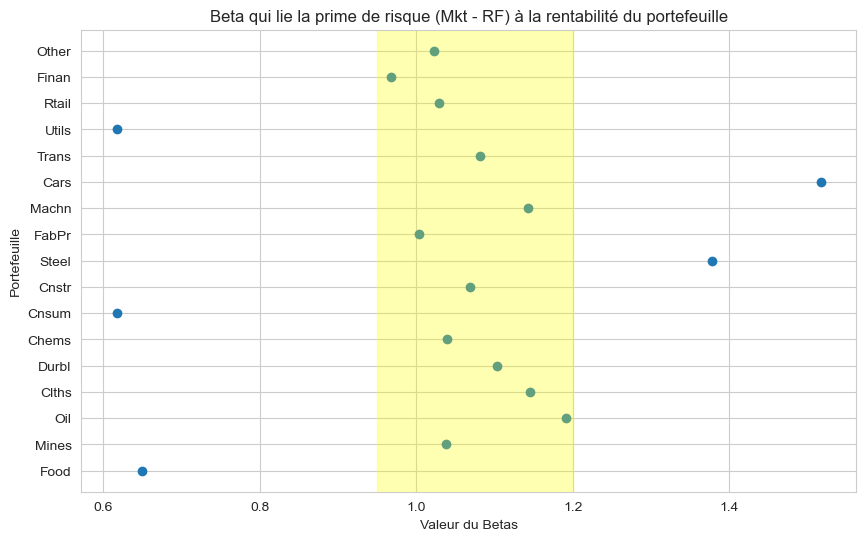

In [143]:
plt.figure(figsize=(10, 6))
plt.scatter(dataFrameBetas['Mkt-RF'], dataFrameBetas.index)

plt.title('Beta qui lie la prime de risque (Mkt - RF) à la rentabilité du portefeuille')
plt.xlabel('Valeur du Betas')
plt.ylabel('Portefeuille')
plt.grid(True)
plt.axvspan(0.95, 1.2, color='yellow', alpha=0.3)

# Ce graphique est TRES instructif, nous avons tracé une bande jaune pour mettre en évidence
# l'intervalle dans lequel se situe la majorité des betas qui lient la prime de risque au rendement
# du secteur étudié, soit entre 0.95 et 1.2
# Regardez cependant les secteurs dont le betas est plus faible sur la gauche
# Le secteur de l'alimentation possède un rendement qui dépend moins des chocs du marché en général
# à l'inverse sur la droite, le secteur des voitures subit les vraiations du marché avec un effet
# amplifié

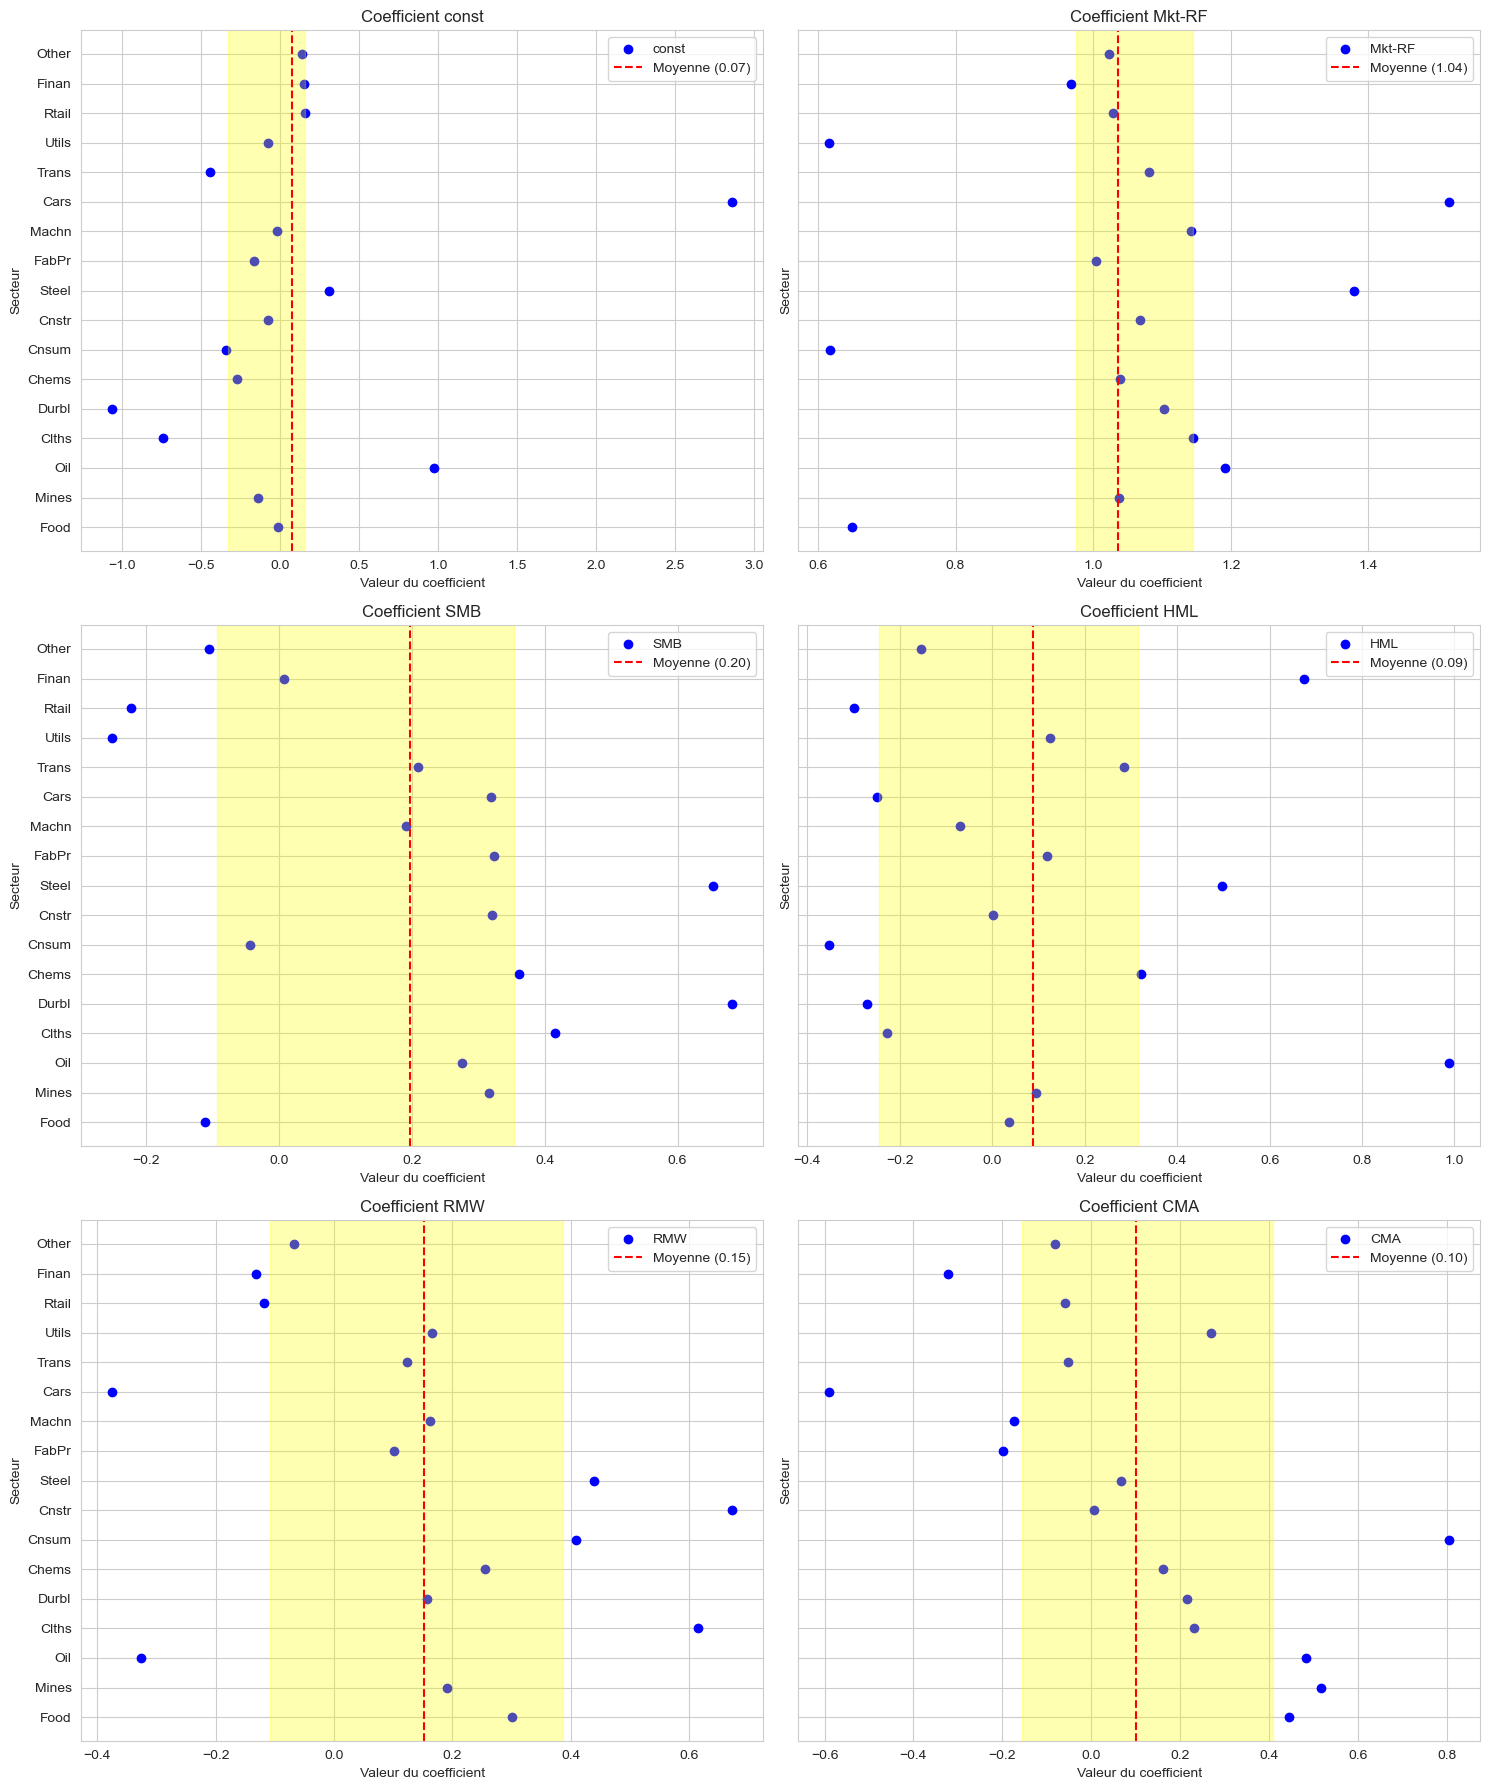

In [159]:
import matplotlib.pyplot as plt

# Création de la figure et des sous-graphiques sur 3 lignes et 2 colonnes
fig, axs = plt.subplots(3, 2, figsize=(15, 18), sharey=True)

# Liste des coefficients à ploter
coefficients = ['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Boucle sur chaque coefficient pour ploter un graphique
for i, coeff in enumerate(coefficients):
    row = i // 2  # Calcul de la ligne (0, 1 ou 2)
    col = i % 2   # Calcul de la colonne (0 ou 1)
    
    ax = axs[row, col]
    ax.scatter(dataFrameBetas[coeff], dataFrameBetas.index, color='blue', label=coeff)
    ax.set_title(f'Coefficient {coeff}')
    ax.set_xlabel('Valeur du coefficient')
    ax.set_ylabel('Secteur')
    ax.grid(True)
    
    # Calcul de la moyenne
    mean_value = dataFrameBetas[coeff].mean()
    
    # Plot vertical de la moyenne
    ax.axvline(mean_value, color='red', linestyle='--', label=f'Moyenne ({mean_value:.2f})')
    
    # Calcul des percentiles
    p20 = dataFrameBetas[coeff].quantile(0.2)
    p80 = dataFrameBetas[coeff].quantile(0.8)
    
    # Coloration de la zone entre les 5e et 95e percentiles
    ax.axvspan(p20, p80, color='yellow', alpha=0.3)
    
    ax.legend()  # Ajout de la légende au graphique

# Ajustement automatique des espacements entre les sous-graphiques
plt.tight_layout()

# Affichage de la figure avec tous les sous-graphiques
plt.show()
